# QNL GDS Factory Tutorial
Elias Lehman 3/16/2024

This documentation is intended to help QNL members effectively navigate GDS Factory. 

Follow the following steps to get started using GDS Factory:

1. Install [https://www.klayout.de/build.html](KLayout) - open source GDS visualization software.

2. Add klive extension (Tools --> Manage packages --> Install new packages) - allows autmoatic update of visualization.

3. Install GDS Factory by running the following cell:

In [1]:
# !pip install gdsfactory --upgrade --user

4. Check that GDS Factory is install correctly:

In [2]:
import sys
print(sys.version)
print(sys.executable)

import gdsfactory as gf
gf.config.print_version_plugins()

3.11.0 (main, Oct 25 2022, 14:13:24) [Clang 14.0.0 (clang-1400.0.29.202)]
/usr/local/opt/python@3.11/bin/python3.11


                                                      Modules                                                      
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Package ┃ version                                          ┃                                            Path ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     python │ 3.11.0 (main, Oct 25 2022, 14:13:24) [Clang      │       /usr/local/opt/python@3.11/bin/python3.11 │
│            │ 14.0.0 (clang-1400.0.29.202)]                    │                                                 │
│ gdsfactory │ 8.1.0                                            │ /Users/elias/Library/Python/3.11/lib/python/si… │
│   gplugins │ not installed                                    │                                                 │
│        ray │ not installed                                    │                                                 │
│    femwell │ not installed                                    │                                                 │
│     devsim │ not installed                                    │                                                 │
│     tidy3d │ not installed                                    │                                                 │
│       meep │ not installed                                    │                                                 │
│       meow │ not installed                                    │                                                 │
│     lumapi │ not installed                                    │                                                 │
│        sax │ not installed                                    │                                                 │
└────────────┴──────────────────────────────────────────────────┴─────────────────────────────────────────────────┘

5. Install the klayout generic pdk (layermap and DRC):

In [3]:
! gf install-klayout-genericpdk

removing /Users/elias/.klayout/salt/gdsfactory already installed
Symlink made:
From: /Users/elias/Library/Python/3.11/lib/python/site-packages/gdsfactory/generic_tech/klayout
To:   /Users/elias/.klayout/salt/gdsfactory


6. Test Component module. Restart KLayout such that klive is active!

In [4]:
def bend(radius: float = 5) -> gf.typings.Component:
    return gf.components.bend_euler(radius=radius, )

component = bend(radius=10)
component.show()

2024-06-27 10:56:18.659 | INFO     | kfactory.kcell:show:7769 - klive v0.3.0: Opened file '/Users/elias/Desktop/School/Quantum/AQT/build/gds/523177875.oas'


In [1]:
import gdsfactory as gf
from qnlfactory import *
import math
import numpy as np
from gdsfactory.cross_section import ComponentAlongPath
import qnlmodels.cpw as CPW
import qnlmodels.klopfenstein_taper as kt

In [96]:
cell_layout = EmbeddedSnail(cell_height=282.5, cell_width=95, r=0.1, 
                            junction_width=1, junction_height=2, snail_gap_height=3, 
                            finger_gap=3, finger_pad=3, finger_width=3, 
                            snail_cap_height=14, snail_cap_lead_width=3, snail_cap_width=20)
cell_layout.unit_cell().show()
# cell_layout.draw_chain(8)

2024-06-27 15:06:20.840 | INFO     | kfactory.kcell:show:7769 - klive v0.3.0: Opened file '/Users/elias/Desktop/School/Quantum/AQT/build/gds/1843280464.oas'


In [172]:
class ReverseKerrTWPA:
    def __init__(self, chip_width, chip_height, cell_impedance, margin,
                 segment_spacing, taper_segment_spacing, mid_freq, 
                 num_paths, num_taper_paths, cell, launch_dims = [250, 250, 250]):
        
        # Substrate parameters
        self.chip = gf.components.die(
                    size=(chip_width, chip_height),  # Size of die
                    street_width=0,  # Width of corner marks for die-sawing
                    street_length=1000,  # Length of corner marks for die-sawing
                    die_name="RevKerrTWPA",  # Label text
                    text_size=70,  # Label text size
                    text_location="NE",  # Label text compass location e.g. 'S', 'SE', 'SW'
                    layer=(20, 0),
                    bbox_layer=(5, 0)
                )
        
        self.chip_width = chip_width
        self.chip_height = chip_height
        
        self.cell = cell
        self.cell_height = cell.cell_height
        self.cell_width = cell.cell_width
        
        self.mid_freq = mid_freq
        self.cell_impedance = cell_impedance

        self.segment_spacing = segment_spacing
        self.taper_segment_spacing = taper_segment_spacing
        self.num_paths = num_paths
        self.num_taper_paths = num_taper_paths
        self.margin = margin

        self.launch_dims = launch_dims
    
        self.total_devices = 0

    def draw(self):
        twpa = self.make()
        twpa.show()

    def make(self):
        twpa = gf.Component()
        twpa.add_ref(self.chip)
        metal = gf.components.rectangle(size=(self.chip_width, self.chip_height), layer=(1,0), centered=True)

        amp_cpw = CPW.CPW(self.cell.snail_gap_height, self.cell.snail_gap_height, 675, 11.7)
        amp_cpw = CPW.CPW(self.cell.snail_gap_height, amp_cpw.solve_for_impedance(self.cell_impedance,'s'), 675, 11.7)
        cpw_50_ohms = CPW.CPW(amp_cpw.solve_for_impedance(50,'w'), amp_cpw.solve_for_impedance(self.cell_impedance,'s'), 675, 11.7)

        turn_radius = self.segment_spacing/2 + self.cell_height/2 + self.cell.finger_pad
        taper_turn_radius = self.taper_segment_spacing/2 + cpw_50_ohms.width/2

        segment_length = self.chip_height-2*(self.margin)-2*(turn_radius)
        taper_segment_length = self.chip_height - 2*(self.margin) - (turn_radius) - self.launch_dims[2]

        taper_length = (2*taper_segment_length+segment_length*(self.num_taper_paths-2))*1e-6
        f = self.mid_freq / 2 / np.pi
        wavelength = cpw_50_ohms.phase_velocity() / f
        B = 2 * np.pi / wavelength
        A = B * taper_length
        print("Taper length = {:.3f}".format(taper_length))
        print("A = {:.3f}".format(A))
        print("COSH(A) [dB] = {:.3f}".format(np.arccosh(10**(A/20))))
        taper = kt.KlopfensteinTaper(A)
        req_z0s = taper.get_all_impedances(50, self.cell_impedance)
        widths = np.array([cpw_50_ohms.solve_for_impedance(z0, 'w') for z0 in req_z0s])
        rev_widths = np.flip(widths)

        def round_to_even_float(x):
            return round(x/2,3)*2

        def taper_width_function(x, widths, spacing=0):
            """ Args:
            x : normalized N-vector (0 < x[i] < 1 for all i)
            
            Returns: 
            width : N-vector of widths
            """  
            width_array = []
            N = len(x)
            M = len(widths)
            for i in range(N):
                w = round_to_even_float(widths[int(i*M/N)]+spacing) if round(widths[int(i*M/N)]+spacing,3) % 2 else round(widths[int(i*M/N)]+spacing,3)
                width_array = np.append(width_array, [w])
            return width_array
        
        start = (-self.chip_width/2+self.margin+self.launch_dims[1]/2, self.chip_height/2-self.margin-self.launch_dims[2])

        taper_trace_in = Trace(width=cpw_50_ohms.w, spacing=cpw_50_ohms.s, width_func=lambda x: taper_width_function(x, widths))

        launch_in = Launch(taper_trace_in, pad_width=self.launch_dims[0], pad_height=self.launch_dims[1], taper_length=self.launch_dims[2], angle=-90)
        launch_ref = twpa << launch_in.make()
        launch_ref.dmove(start)
        
        taper_trace_in.straight(taper_segment_length)
        for i in range(2):
            taper_trace_in.turn(radius=taper_turn_radius, angle=180*(-1)**(i)).straight(taper_segment_length)
        for i in range(self.num_taper_paths-2):
            taper_trace_in.turn(radius=taper_turn_radius, angle=180*(-1)**(i)).straight(segment_length)
        taper_trace_in.turn(radius=turn_radius, angle=180)
        cpw_in_route = taper_trace_in.make()
        twpa.add_ref(cpw_in_route).drotate(-90).dmove(start)

        cutout = gf.Component()

        taper_trace_in_s = Trace(width=taper_trace_in.line_width+2*taper_trace_in.line_spacing, spacing=0)
        # twpa << taper_trace_in_s.make()

        launch_in_cpw = CPW.CPW(self.launch_dims[0], self.launch_dims[0], 675, 11.7)
        # print(self.launch_dims[0]+2*launch_in_cpw.solve_for_impedance(50,'s', bounds=(1e-3, 400)))
        launch_spacing = launch_in_cpw.solve_for_impedance(50,'s', bounds=(1e-3, 400))
        launch_in_cutout_frame = Launch(taper_trace_in_s, pad_width=self.launch_dims[0], 
                                        pad_height=round_to_even_float(self.launch_dims[1]+2*launch_spacing), 
                                        taper_length=self.launch_dims[2], angle=-90)
        launch_cutout_frame_ref = launch_in_cutout_frame.make()
        # twpa.add_ref(launch_cutout_frame_ref).dmove(start)

        launch_in_cutout = gf.Component()
        launch_in_cutout.add_polygon(gf.kdb.Region(launch_cutout_frame_ref.get_polygons()[1]),(1,0))
        cutout.add_ref(launch_in_cutout).dmove(start)
        cutout.add_ref(gf.components.rectangle((round_to_even_float(self.launch_dims[1]+2*launch_spacing), 
                                                launch_spacing), 
                                                layer=(1,0))).dmove((start[0]-(self.launch_dims[1]/2+launch_spacing),
                                                                    start[1]+self.launch_dims[2]))

        cpw_in_cutout = gf.Component()
        cpw_in_cutout.add_polygon(gf.kdb.Region(cpw_in_route.get_polygons()[1]).sized(taper_trace_in.line_spacing*1e3), (1,0)) #in nm
        cpw_in_cutout.add_ports(cpw_in_route)
        cutout.add_ref(cpw_in_cutout).drotate(-90).dmove(start)
        
        start = (start[0]+self.num_taper_paths*2*taper_turn_radius+2*turn_radius, -segment_length/2)
        amp_trace = Trace(width=self.cell.snail_gap_height, spacing=3)
        turn = twpa.add_ref(amp_trace.make()).drotate(90).dmove(start)

        N_lin_cells = 2*math.floor(segment_length / 2 / self.cell_width)
    
        chain_cutout = gf.Component()
        turn_cutout = gf.Component() 
        
        for i in range(self.num_paths):
            
            chain = twpa.add_ref(self.cell.chain_cells(N_lin_cells))
            chain.connect("in", turn["out_w"])

            chain_cutout.add_port(name="in", center=[self.cell_height/2, N_lin_cells*self.cell_width], width=self.cell.snail_gap_height, orientation=90, layer=(1,0))
            chain_cutout.add_port(name="out", center=[self.cell_height/2, 0], width=self.cell.snail_gap_height, orientation=-90, layer=(1,0))
            
            chain_cutout.add_polygon(gf.kdb.Region(self.cell.chain_cells(N_lin_cells).get_polygons()[1]).sized(self.cell.finger_pad*1e3), (1,0))
            chain_cutout_ref = cutout.add_ref(chain_cutout)
            chain_cutout_ref.connect("in", turn["out_w"])

            amp_trace = Trace(width=self.cell.snail_gap_height, spacing=3)
            amp_trace.turn(radius=turn_radius, angle=180*(-1)**(i+1))
            turn = twpa.add_ref(amp_trace.make())
            turn.connect("in_w", chain.ports["out"])

            turn_cutout.add_port(name="in_w", center=[0, 0], width=self.cell.snail_gap_height, orientation=180, layer=(1,0))
            turn_cutout.add_port(name="out_w", center=[0, -2*turn_radius], width=self.cell.snail_gap_height, orientation=180, layer=(1,0))
            
            if i == 0:
                turn_cutout.add_polygon(gf.kdb.Region(amp_trace.make().get_polygons()[1]).sized(taper_trace_in.line_spacing*1e3), (1,0))
            turn_cutout_ref = cutout.add_ref(turn_cutout)
            if i % 2:
                turn_cutout_ref.connect("out_w", chain.ports["out"])
            else:
                turn_cutout_ref.connect("in_w", chain.ports["out"])

        print(f"{N_lin_cells*(self.num_paths-2)} cells") 
        
        taper_trace_out = Trace(width=cpw_50_ohms.w, spacing=cpw_50_ohms.s, width_func=lambda x: taper_width_function(x, rev_widths))
        taper_trace_out = taper_trace_out.straight(segment_length)
        for i in range(self.num_taper_paths-3):
            taper_trace_out.turn(radius=taper_turn_radius, angle=180*(-1)**(i+1)).straight(segment_length)
        for i in range(3):
            taper_trace_out.turn(radius=taper_turn_radius, angle=180*(-1)**(i)).straight(taper_segment_length)
        cpw_out_route = taper_trace_out.make()

        start = (start[0]+2*(self.num_paths)*turn_radius, -segment_length/2)

        twpa.add_ref(cpw_out_route).drotate(90).dmove(start)
        cpw_out_cutout = gf.Component()
        cpw_out_cutout.add_polygon(gf.kdb.Region(cpw_out_route.get_polygons()[1]).sized(taper_trace_out.line_spacing*1e3), (1,0)) #in nm
        cutout.add_ref(cpw_out_cutout).drotate(90).dmove(start)
            
        launch_in_cutout_frame = Launch(taper_trace_in_s, pad_width=self.launch_dims[0], 
                                        pad_height=round_to_even_float(self.launch_dims[1]+2*launch_spacing), 
                                        taper_length=self.launch_dims[2], angle=-90)
        launch_cutout_frame_ref = launch_in_cutout_frame.make()

        launch_out = Launch(taper_trace_out, pad_width=self.launch_dims[0], pad_height=self.launch_dims[1], taper_length=self.launch_dims[2], port="out_w", angle=90)
        launch_out_ref = twpa << launch_out.make()
        launch_out_ref.dmove(start)
        
        start = (start[0]+2*self.num_taper_paths*taper_turn_radius, self.chip_height/2-self.margin-self.launch_dims[2])

        launch_out_cutout = gf.Component()
        launch_out_cutout.add_polygon(gf.kdb.Region(launch_cutout_frame_ref.get_polygons()[1]),(1,0))
        cutout.add_ref(launch_out_cutout).dmove(start)
        cutout.add_ref(gf.components.rectangle((round_to_even_float(self.launch_dims[1]+2*launch_spacing), 
                                                launch_spacing), 
                                                layer=(1,0))).dmove((start[0]-(self.launch_dims[1]/2+launch_spacing),
                                                                    start[1]+self.launch_dims[2]))

        twpa.add_ref(gf.boolean(A=metal, B=cutout, operation='not', layer=(1,0)))


        #AQT Logo
        # aqt_logo = twpa << gf.import_gds(gdspath="../GDS_assets/AQT.gds", cellname='AQT', flatten=False)
        # aqt_logo.dmove((-self.chip_width/2+250, self.chip_height/2-175))
        
        return twpa

    def embed_cells(self, path):
        """Function to extrude cells onto path.
            DEPRECATED!
        """
        unit_cells = ComponentAlongPath(component = self.cell.alt_cells(), spacing = 2*self.cell_width)
        x = gf.CrossSection(components_along_path=[unit_cells])
        embedded_cells = gf.path.extrude(path, cross_section=x)
        return embedded_cells


In [175]:
TWPA = ReverseKerrTWPA(chip_height=9000, chip_width=9000, cell_impedance=50,
                       margin = 150, segment_spacing=150, cell=cell_layout, launch_dims=[150,150,300],
                       mid_freq=7.5e9, num_paths=10, num_taper_paths=10, taper_segment_spacing = 150)
# TWPA.make().show()
TWPA.make().write_gds("RevKerrTWPA.gds")

Taper length = 0.082
A = 5.196
COSH(A) [dB] = 1.205
2024-06-28 13:21:44.633 | WARNING  | gdsfactory.component:__getattribute__:126 - Getting `taper_cross_section_CSx_1dbc00d4_-150000_0.rotate` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `taper_cross_section_CSx_1dbc00d4_-150000_0.drotate` instead. For further information, please consult the migration guide https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-06-28 13:21:44.920 | WARNING  | gdsfactory.component:__getattribute__:126 - Getting `taper_cross_section_CSx_934cfeff_-150000_0.rotate` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `taper_cross_section_CSx_934cfeff_-150000_0.drotate` instead. For further information, please consult the migration guide https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
688 cells
2024-06-28 13:21:46.270 | WARNING  | gdsfactory.component:__getattribute__:126 - Getting `taper_

PosixPath('RevKerrTWPA.gds')

In [10]:
import gdsfactory as gf

c = gf.components.taper_from_csv(filepath= 'impedance_values.csv', cross_section='xs_m1')
c.show()
c2 = gf.components.taper_from_csv(filepath= 'outgoing_impedance_values.csv', cross_section='xs_m1')
c2.show()

2024-06-27 10:56:43.430 | ERROR    | kfactory.kcell:wrapper_autocell:3332 - An error has been caught in function 'wrapper_autocell', process 'MainProcess' (85022), thread 'MainThread' (4483216896):
Traceback (most recent call last):

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/elias/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
    │   └ <bound method Application.launch_instance of <class 'ipykernel.kernelapp.IPKernelApp'>>
    └ <module 'ipykernel.kernelapp' from '/Users/elias/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py'>
  File "/Users/elias/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
    │   └ <function IPKernelApp.start at 0x108148720>
    └ <ipykernel.kernelapp.IPKernelApp object at 0x104faab50>
  File "/Users/elias/Library/Python

ValueError: 'xs_m1' not in ['cross_section', 'heater_metal', 'l_wg', 'l_wg_doped_with_trenches', 'l_with_trenches', 'metal1', 'metal2', 'metal3', 'metal_routing', 'metal_slotted', 'nitride', 'npp', 'pin', 'pn', 'pn_ge_detector_si_contacts', 'pn_with_trenches', 'pn_with_trenches_asymmetric', 'rib', 'rib2', 'rib_bbox', 'rib_heater_doped', 'rib_heater_doped_via_stack', 'rib_with_trenches', 'slot', 'strip', 'strip_heater_doped', 'strip_heater_doped_via_stack', 'strip_heater_metal', 'strip_heater_metal_undercut', 'strip_nitride_silicon_tip', 'strip_nitride_tip', 'strip_rib_tip', 'strip_sc_tip']

In [7]:
import gdsfactory as gf
chip = gf.Component()
metal = gf.components.rectangle(size=(750,750), layer=(1,0), centered=True)
cpw = Trace(spacing=1, width=1)
cpw_route = cpw.straight(50).half_segment(500,20).meander(10, 500, 20).straight(250).half_segment(250, 20).make()
cpw_cutout = gf.kdb.Region(cpw_route.get_polygons()[1]).sized(cpw.line_spacing*1e3) #in nm
cutout = gf.Component()
cutout.add_polygon(cpw_cutout, (1,0))
chip.add_ref(cpw_route)
chip.add_ref(gf.boolean(A=metal, B=cutout, operation='not', layer1=(1,0), layer2=(1,0), layer=(1,0)))
chip.show()

2024-06-27 10:56:20.409 | INFO     | kfactory.kcell:show:7769 - klive v0.3.0: Opened file '/Users/elias/Desktop/School/Quantum/AQT/build/gds/3949248572.oas'


In [ ]:
init_cpw = CPW.CPW(2, 2, 600, 11.7)
cpw_50_ohms = CPW.CPW(init_cpw.solve_for_impedance(50,'w'), 2, 600, 11.7)

segment_length = 5000-2.5*(100)-2*(50)
taper_segment_length = segment_length - 250 - 250

taper_length = taper_segment_length*25
wavelength = cpw_50_ohms.phase_velocity() / 7.5e9
B = 2 * np.pi / wavelength
A = B * taper_length

taper = kt.KlopfensteinTaper(A)

def taper_width_function(x):
    """ Args:
    x : normalized N-vector (0 < x[i] < 1 for all i)
    
    Returns: 
    width : N-vector of widths
    
    """
    req_z0s = taper.get_impedance(50, 86, np.size(x))
    width = np.array([cpw_50_ohms.solve_for_impedance(z0, 'w') for z0 in req_z0s])
    return width


trace = Trace(width=cpw_50_ohms.w, spacing=cpw_50_ohms.s, width_func=taper_width_function)
trace.draw()

PydanticSerializationError: Error calling function `serialize_functions`: TypeError: 'int' object is not iterable

2024-06-18 13:15:54.099 | WARNING  | gdsfactory.component:__getattribute__:126 - Getting `rectangle_S4_3_LWG_CFal_a216d6e3_2000_1500.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `rectangle_S4_3_LWG_CFal_a216d6e3_2000_1500.dmove` instead. For further information, please consult the migration guide https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-06-18 13:15:54.260 | WARNING  | gdsfactory.component:__getattribute__:126 - Getting `rectangle_S4_0p6_LWG_CF_84fd82ea_2000_300.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `rectangle_S4_0p6_LWG_CF_84fd82ea_2000_300.dmove` instead. For further information, please consult the migration guide https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-06-18 13:15:54.263 | WARNING  | gdsfactory.component:__getattribute__:126 - Getting `rectangle_S0p2_2_LWG_CF_9ef6d549_100_1000.move` in um is deprecated and will c

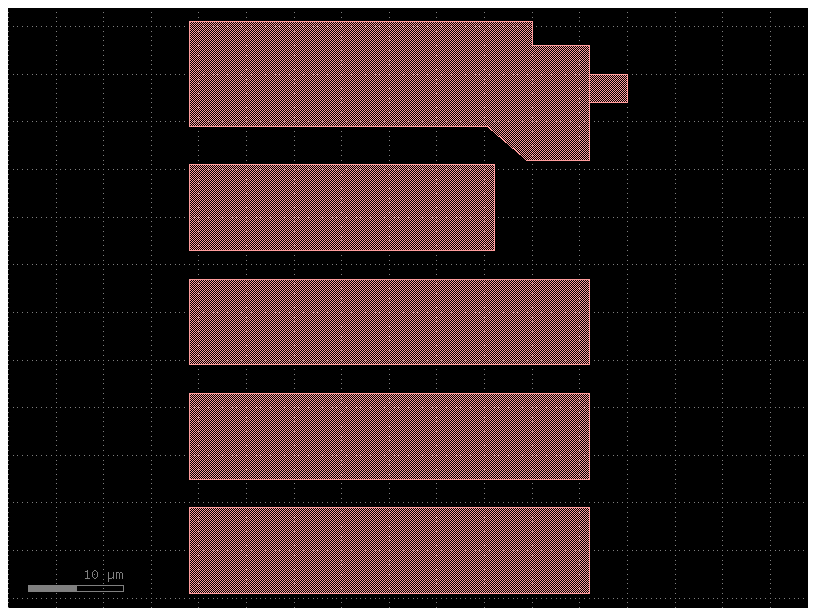

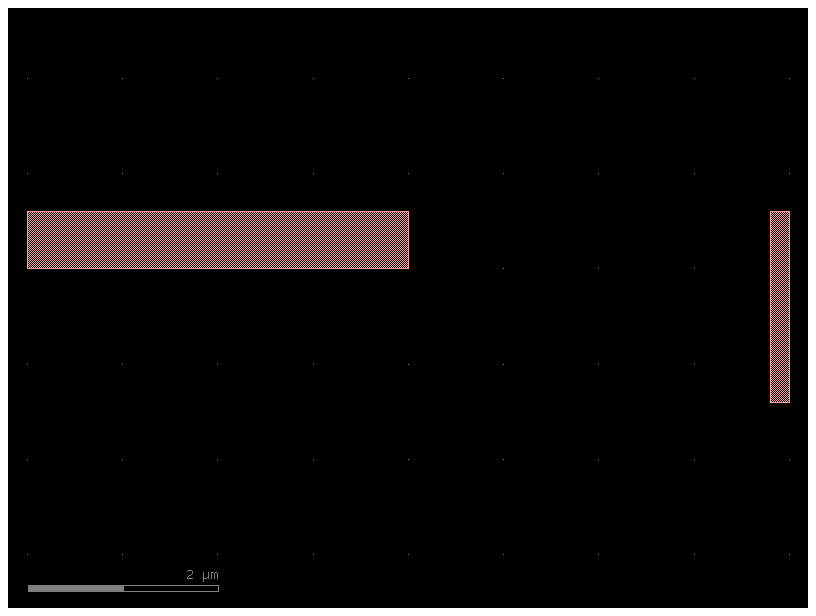

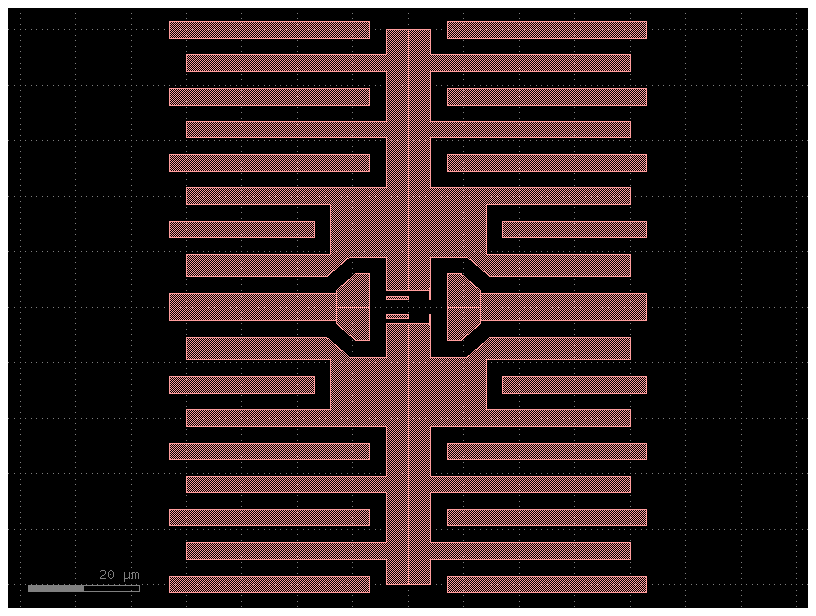

In [ ]:
import gdsfactory as gf

frame = gf.components.rectangle(size=(40, 50), layer=(2, 0))

long_finger_crosssection = gf.CrossSection(sections=[gf.Section(width=3, offset=0, layer=(1, 0), port_names=("in", "out"))])
long_fingers = gf.components.straight_array(n=3, spacing=9, length=36, cross_section=long_finger_crosssection)

short_finger_crosssection = gf.CrossSection(sections=[gf.Section(width = 3, offset=0, layer=(1, 0), port_names=("in", "out"))])
short_finger = gf.components.straight(length=26, cross_section=short_finger_crosssection)

fingers = gf.Component()
fingers.add_ref(long_fingers).dmovex(-3)
fingers.add_ref(short_finger).dmove((-3,36))

cap_pad_stem_crosssection = gf.CrossSection(sections=[gf.Section(width=5, offset=0, layer=(1, 0), port_names=("in", "out"))])
cap_pad_stem = gf.components.straight(length=30, cross_section=cap_pad_stem_crosssection)
cap_pad_top = gf.components.triangle(x=6, xtop=3, y=6, ybot=2.5, layer=(1,0))

cap_pad = gf.Component()
cap_pad.add_ref(cap_pad_stem).dmove((-3,50))
cap_pad.add_ref(cap_pad_top).mirror_y().drotate(-90).dmove((33,50))

finger_gaps = gf.kdb.Region(fingers.get_polygons()[1]).sized(3e3) #in nm
cap_pad_gap = gf.kdb.Region(cap_pad.get_polygons()[1]).sized(3e3)
junctions_gap = gf.components.rectangle(size=(4,3))

gaps = gf.Component()
gaps.add_polygon(finger_gaps, (1,0))
gaps.add_polygon(cap_pad_gap, (1,0))
gaps.add_ref(junctions_gap).move((36,47))
gaps.plot()
subtract_gaps = gf.boolean(A=frame, B=gaps, operation="not", layer1=(2, 0), layer2=(1, 0), layer=(1, 0))

E = gf.Component()
E.add_ref(subtract_gaps)
E.add_ref(fingers)
E.add_ref(cap_pad)

large_junction_spacing = gf.components.rectangle(size=(4, 0.6))
small_junction_spacing = gf.components.rectangle(size=(0.2, 2))

junction_spacings = gf.Component()
junction_spacings.add_ref(large_junction_spacing).move((0, -2))
junction_spacings.add_ref(small_junction_spacing).move((4+3.8, -3.4))
junction_spacings.plot()

cell = gf.Component()
cell.add_ref(E)
cell.add_ref(E).mirror_x().dmovex(80)
cell.add_ref(E).mirror_y().dmovey(100)
cell.add_ref(E).mirror_y().mirror_x().dmove((80, 100))
cell.add_ref(junction_spacings).move((36, 50))
cell.add_ref(junction_spacings).mirror_y().move((36, 50))
cell.plot()

In [84]:
lp = gf.Component()

amp_cpw = CPW.CPW(3, 5, 675, 11.7)
amp_cpw = CPW.CPW(3, amp_cpw.solve_for_impedance(86,'s'), 675, 11.7)
cpw_50_ohms = CPW.CPW(amp_cpw.solve_for_impedance(50,'w'), amp_cpw.solve_for_impedance(86,'s'), 675, 11.7)
cpw = Trace(width=round(cpw_50_ohms.w/2)*2, spacing=cpw_50_ohms.s)

section = []
section.append(gf.Section(width=cpw.line_width, offset=0, layer=(1, 0), name = f'line_w', port_names=(f'in_w', f'out_w')))
# section.append(gf.Section(width=10+2*5, offset=0, layer=(2, 0), name = f'line_s', port_names=(f'in_s', f'out_s')))
outgoing_cross_section = gf.CrossSection(sections = section)

launch_pad_cross_section = Trace(spacing=10, width=250).get_cross_section()
transition = lp << gf.components.taper_cross_section(cross_section1=outgoing_cross_section, 
                                                cross_section2=launch_pad_cross_section,
                                                length=270, 
                                                linear=False,
                                                width_type="sine")

transition.connect("in_w", cpw.make().ports["out_w"])

# semi_circle = gf.boolean(A=gf.components.circle(radius=250/2), B=gf.components.rectangles(size=(250/2, 250), offsets=(0,0), centered=True), operation='not', layer=(1,0))
# semi_circle.add_ports(transition.ports)
# pad = lp << semi_circle
# pad.connect("out_w", transition.ports["out_w"])
# pad.movey(250/2)

lp.show()

2024-06-27 14:43:17.813 | WARNING  | gdsfactory.component:__getattribute__:126 - Getting `Unnamed_2986_540000_0.movey` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_2986_540000_0.dmovey` instead. For further information, please consult the migration guide https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-06-27 14:43:18.073 | INFO     | kfactory.kcell:show:7769 - klive v0.3.0: Opened file '/Users/elias/Desktop/School/Quantum/AQT/build/gds/912397709.oas'
